# Predicting food cost with a menu corpus

The menu corpus used here contains descriptions of over 500,000 dishes from restaurants in 7 cities.

Jurafsky, Dan, 2016, "Linguistic Markers of Status in Food Culture: Bourdieu's Distinction in a Menu Corpus" data and scripts", https://doi.org/10.7910/DVN/QMLCPD, Harvard Dataverse, V1

## Read in dataset

In [1]:
import pandas as pd
import csv
import numpy as np


def add_feature(df, word):
    df[word] = [1 if word in text.split() else 0 for text in df["dish_description"]]
    return df


def read_menu_dataset(data_path="menuitems.raw"):
    result = []
    with open(data_path, 'r') as f:
        for line in f:
            line_split = line.split("+")
            if len(line_split) != 7:
                continue
            line_split = [item.strip() for item in line_split]
            if line_split[6] == "NA":
                continue
            line_split[6] = float(line_split[6])
            result.append(line_split)

    df = pd.DataFrame(
        result, columns=["restaurant", "restaurant_type", "city", "dollar_signs",
                         "dish_name", "dish_description", "dish_cost"])
    
    df = df.join(pd.get_dummies(df["city"]))
    df = df.join(pd.get_dummies(df["restaurant_type"]))

    return df
    
    
menu_dataset = read_menu_dataset()


## Plot average cost by city and restaurant type

This is mainly to let students get familiar with the dataset and see that these features might be predictive of dish cost.

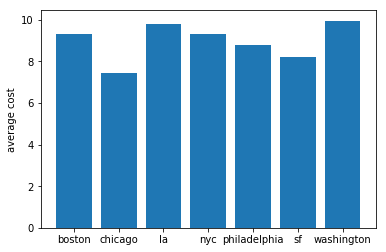

In [3]:
import matplotlib.pyplot as plt


CITIES = sorted(list(set(menu_dataset["city"])))

average_costs = []
for city in CITIES:
    city_costs = menu_dataset[menu_dataset["city"] == city]["dish_cost"]
    average_costs.append(np.mean(city_costs))

plt.bar(CITIES, average_costs)
plt.ylabel("average cost")
plt.show()

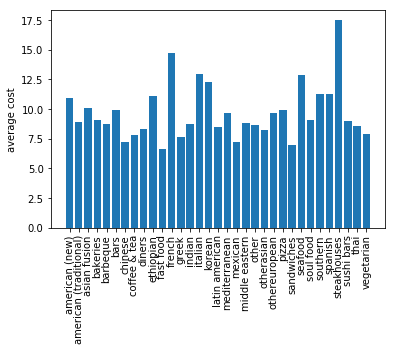

In [4]:
import matplotlib.pyplot as plt


RESTAURANT_TYPES = sorted(list(set(menu_dataset["restaurant_type"])))

average_costs = []
for restaurant_type in RESTAURANT_TYPES:
    curr_costs = menu_dataset[menu_dataset["restaurant_type"] == restaurant_type]["dish_cost"]
    average_costs.append(np.mean(curr_costs))

plt.bar(RESTAURANT_TYPES, average_costs)
plt.xticks(rotation=90)
plt.ylabel("average cost")
plt.show()

## Plot average cost by preparation method

This lets students practice extracting features from text.

586784it [01:29, 6521.52it/s]


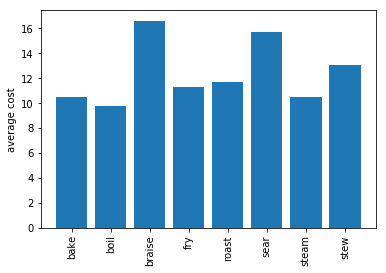

In [5]:
from collections import defaultdict
from tqdm import tqdm

PREPARATION_METHODS = sorted(["stew", "boil", "braise", "roast", "fry", "bake", "sear", "steam"])
preparation_method_to_cost = defaultdict(list)

for row in tqdm(menu_dataset.iterrows()):
    for preparation_method in PREPARATION_METHODS:
        if preparation_method in row[1]["dish_description"]:
            preparation_method_to_cost[preparation_method].append(row[1]['dish_cost'])
            
preparaton_costs = [np.mean(preparation_method_to_cost[prep_method])
                    for prep_method in PREPARATION_METHODS]
plt.bar(PREPARATION_METHODS, preparaton_costs)
plt.xticks(rotation=90)
plt.ylabel("average cost")
plt.show()


## Regression experiment and feature engineering with keywords

I was thinking here we could challenge students to work in pairs and find 5 words that result in the highest r-squared on the test dataset.

I think we should provide most of the code for this part.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


RANDOM_STATE = 333
np.random.seed(RANDOM_STATE)


def add_feature(dataset, keyword):
    keyword_label = "_".join(keyword.split())
    dataset[keyword_label] = [
        1 if keyword in text.lower() else 0 for text in dataset["dish_description"]]
    return dataset


def run_regression_experiment(
        menu_dataset, keyword_features=[], verbose=False):
    menu_dataset = menu_dataset.copy()
    for keyword in keyword_features:
        menu_dataset = add_feature(menu_dataset, keyword)
    
    menu_dataset["description_length"] = [
        len(text.split()) for text in menu_dataset["dish_description"]]
    menu_dataset["avg_word_length"] = [
        np.mean([len(word) for word in text.split()]) if text != "" else 0
        for text in menu_dataset["dish_description"]]
    
    X = menu_dataset[[item for item in menu_dataset.columns if item not in
                      ["restaurant", "dish_name", "dollar_signs",
                       "city", "restaurant_type", "dish_description",
                       "dish_cost"]]]
    y = menu_dataset["dish_cost"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_STATE)
    
    reg = LinearRegression().fit(X_train, y_train)
    print(f"r-squared score on train = {reg.score(X_train, y_train):.4f}")
    print(f"r-squared score on test = {reg.score(X_test, y_test):.4f}")

    if verbose:
        print("\n\nCoefficients:\n")
        for a, b in zip(reg.coef_, X.columns):
            print(f"{b}: \t\t{a:.4f}")

In [7]:
# Experiment without keywords.

run_regression_experiment(menu_dataset, verbose=True)

r-squared score on train = 0.1293
r-squared score on test = 0.1174


Coefficients:

boston: 		-0.0950
chicago: 		-0.9848
la: 		0.2967
nyc: 		0.6836
philadelphia: 		-0.2110
sf: 		-0.4620
washington: 		0.7725
american (new): 		0.9921
american (traditional): 		-0.9602
asian fusion: 		0.5993
bakeries: 		-0.3044
barbeque: 		-0.3913
bars: 		-0.3073
chinese: 		-1.1915
coffee & tea: 		-1.7471
diners: 		-1.0778
ethiopian: 		0.1617
fast food: 		-2.6683
french: 		4.6577
greek: 		-1.7662
indian: 		-1.7420
italian: 		2.9625
korean: 		2.2288
latin american: 		-0.8972
mediterranean: 		-0.1765
mexican: 		-2.3484
middle eastern: 		-1.2214
other: 		-0.8863
otherasian: 		-1.5105
othereuropean: 		0.2346
pizza: 		0.6390
sandwiches: 		-2.8304
seafood: 		3.9301
soul food: 		0.1535
southern: 		1.3571
spanish: 		1.2899
steakhouses: 		7.8308
sushi bars: 		-0.4957
thai: 		-1.9118
vegetarian: 		-2.6027
description_length: 		0.1495
avg_word_length: 		0.2457


In [9]:
run_regression_experiment(
    menu_dataset, keyword_features=[
        "caviar", "lobster", "bisque", "halibut", "truffle", "sashimi"])

r-squared score on train = 0.1379
r-squared score on test = 0.1249


In [14]:
run_regression_experiment(
    menu_dataset, keyword_features=["you", "chef", "own", "self", "choice"])

r-squared score on train = 0.1306
r-squared score on test = 0.1185


## Determine the best keywords by running individual regressions

There are too many features to use sklearn's SelectKBest (crashes with memory error).

I think we should probably leave this out of the workshop, but I was curious what the most predictive words were.

Most of the words that come out as predictive here are function words (e.g. "a", "and", "on", "or", et.). I expect that this is because higher counts of function words indicate greater syntactic complexity, which is likely positively correlated with dish cost.

In [15]:
from collections import Counter
from tqdm import tqdm


def get_all_words(dataset, min_count=500):
    word_counter = Counter()
    for text in dataset["dish_description"]:
        word_counter.update(text.lower().split())
        
    all_words = [item for item, count in word_counter.items()
                 if item.isalpha() and count >= min_count]
    return all_words


def get_best_features(menu_dataset, feature_list, n_features=20):
    feature_scores = []
    for keyword in tqdm(feature_list):
        X = [[1] if keyword in text.lower() else [0]
             for text in menu_dataset["dish_description"]]
        y = menu_dataset["dish_cost"]
        reg = LinearRegression().fit(X, y)
        score = reg.score(X, y)
        feature_scores.append((keyword, score))
    result = sorted(feature_scores, key=lambda x: x[1], reverse=True)[:n_features]
    return [item[0] for item in result]


ALL_WORDS = get_all_words(menu_dataset)
BEST_FEATURES = get_best_features(menu_dataset, ALL_WORDS)
print(f"BEST_FEATURES={BEST_FEATURES}")

run_regression_experiment(
    menu_dataset, keyword_features=BEST_FEATURES)

100%|██████████| 522/522 [09:55<00:00,  1.24s/it]


BEST_FEATURES=['a', 'an', 'w', 'and', 'it', 'in', 'as', 'sauce', 'on', 'with', 'to', 'y', 'per', 'wine', 'potato', 'mushroom', 'or', 'garlic', 'oz', 'mushrooms']
r-squared score on train = 0.1414
r-squared score on test = 0.1272
